In [1]:
import ast, os, re, time
import requests
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import yfinance as yf

from IPython.display import Markdown, display
from datetime import timedelta, datetime, date
from util import validate_dates

from plots import create_candlestick_chart
from lucerna import Lucerna

In [16]:
import prompts.prompt_templates as pt

In [3]:
yf.__version__

'0.2.59'

## Utils

In [4]:

"""
References:
- https://gist.github.com/leftmove/dd9d981c8c37983f61e423a45085e063#file-ticker-py-L1


"""
def fill_dates(df, fill_value=np.nan):
    """
    Fill datetime index of a dataframe with fill_value.
    
    parameters
    ----------
    df: pd.DataFrame with datetime index
    fill_value: Value to fill columns that gets created. 
    """
    if not isinstance(df.index, pd.DatetimeIndex):
        raise TypeError("Dataframe should have datetime index")
    idx = pd.date_range(df.index[0], df.index[-1])
    df = df.reindex(idx, fill_value=np.nan)
    return df

def get_ticker(company_name):
    """
    Given name of the company, return symbol and stock exchange code.
    *Caveat: This is performing raw api call meaning it could break anytime yahoo
    financial changes its code.
    
    parameters
    ----------
    company_name: str
    """
    yfinance = "https://query2.finance.yahoo.com/v1/finance/search"
    # Sets a fake browser User-Agent string.
    # Some public APIs (like Yahoo's) block or limit access from non-browser clients 
    # (like Python scripts).
    user_agent = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36'
    params = {"q": company_name, "quotes_count": 1, "country": "United States"}
    
    res = requests.get(url=yfinance, params=params, headers={'User-Agent': user_agent})
    data = res.json()
    return data['quotes'][0]['symbol']

## Fundamantal_analysis py

In [5]:
def get_stock_price(ticker, st_date, end_date, interval='1d', timezone=False):
    stock_price_df = ticker.history(start=st_date, end=end_date, interval='1d')
    if not timezone:
        stock_price_df.index = stock_price_df.index.tz_localize(None)
    return stock_price_df

In [94]:
def get_per_df(ticker, stock_price_df, net_income, share_issued):
    """
    PER
    - share price should be after earnings report shift(-1) so that price is adjusted with new earnings info.


    parameters
    ----------
    net_income: pd.Series
    share_issued: pd.Series
    
    """
    # I am assuming shareIssued same as previous if NaN.
    def _fillna(series, method='bfill'):
        old_n_nan_rows = series.isna().sum()
        filled_series = series.bfill()
        print(f'# of filled recent rows: {old_n_nan_rows - filled_series.isna().sum()}')
        return filled_series
    
    eps_df = pd.DataFrame({"net_income":net_income, "share_issued":_fillna(share_issued)})
    eps_df['eps'] = eps_df['net_income'] / eps_df['share_issued']

    # fill non-market day with NaN. This is to easily combine price data with financials.
    df = fill_dates(stock_price_df.copy())
    df['Close_t+1'] = df['Close'].shift(-1).bfill()
    per_df = pd.merge(eps_df, df[['Close_t+1']], how='left',left_index=True, right_index=True)
    per_df['per'] = per_df['Close_t+1'] / per_df['eps']
    return per_df.sort_index()

# One stock analysis

- LG energy solution: 373220.KS
- Samsung Electronics: 005930.KS
- Intel: INTC
- Alphabet: GOOG
- Air Canada: AC.TO

- LS group: 006260.KS

In [7]:
print("Welcome, I am Lucerna, your customized investment advisor!")
ticker = input("What company would you like to know about. Provide ticker symbol:")
ticker = yf.Ticker(ticker)

stock_info = {
    "company_name": ticker.info['longName']
    ,"country": ticker.info['country']
    ,"sector": ticker.info['sector']
    ,"industry": ticker.info['industry']
    ,"business_summary": ticker.info['longBusinessSummary']
    ,"currency": ticker.info['financialCurrency']
    ,"stock_exch": ticker.info['fullExchangeName']}

print()
print(f"You've selected {stock_info['company_name']} to be analyzed.")

Welcome, I am Lucerna, your customized investment advisor!


What company would you like to know about. Provide ticker symbol: 373220.KS



You've selected LG Energy Solution, Ltd. to be analyzed.


In [8]:
n_years = 3
end_date = date.today()
st_date = end_date - timedelta(days=365*n_years)

In [9]:
stock_price_df = get_stock_price(ticker, st_date, end_date, interval='1d', timezone=False)

In [44]:
stock_info['price_df'] = stock_price_df

## 1.1. stock prices and basic info
1. Stock price plot (5y so that user can dynamically change ranges)
2. Basic information of stock.
<br>2.1. History, vision, industry, service products, and future)
<br>2.2. Fundamental analysis with competitors (EPS, marketcap, PER, inside investments, institution investments etc...). Market share.



Keep on updating:
<br>2.1. daily reading news and summarizing news related to them.
<br>2.2. Once in a while when data changes.

In [ ]:
# ??? How to render interative version to web...?

fig_price = create_candlestick_chart(stock_price_df, stock_info['company_name'], stock_info['currency'])
fig_price.show()

print(f"""
Company: {stock_info['company_name']} 
Sector: {stock_info['sector']}
Industry: {stock_info['industry']}
Currency: {stock_info['currency']}
Traded in: {stock_info['stock_exch']}

About:
{stock_info['business_summary']}
""")

In [14]:
# import google.generativeai as genai
# genai.configure(api_key=os.getenv('GEMINI_API_KEY'))
# gemini_text_gen = genai.GenerativeModel('gemini-2.0-flash')
lucerna = Lucerna('gemini', "gemini-2.0-flash")

LLM successfully configured with: GEMINI: gemini-2.0-flash


??? Prompt generator: https://docs.anthropic.com/en/docs/build-with-claude/prompt-engineering/prompt-generator

In [22]:
prompt_company_info = """
You are a value investor with decades of experience. Let's perform a extensive research on {company} to create a report for clients on the buy-side. 
Let's follow steps below:
1. Gather information about the services and products of the {company} and provide statistics.
2. For each service and product, provide information about its market, market share, its major clients (provide company names if applicable) and its competitors. 
3. What risks are associated with current company? (e.g. geopolitical risk in semiconductor industry, oil price in transportation induestry, etc...)

As our clients have high mathematical and finance aptitude, provide table and numbers to explain concisely and clearly.
Do not provide code or explanation of how chart should be created.
"""

In [23]:
"""
One way to draw plots and graphs using LLM is to make them output code then you render it.
"""

resp = lucerna.explain_company(stock_info['company_name'], custom_prompt=prompt_company_info)
display(Markdown(resp))

Okay, here's a comprehensive value investing report on LG Energy Solution (LGES), focusing on key information points relevant to sophisticated buy-side clients.

**LG Energy Solution (LGES): A Value Investment Perspective**

**Executive Summary:**

LG Energy Solution (LGES), a leading global battery manufacturer, is a compelling investment opportunity based on the long-term growth potential of the electric vehicle (EV) market and the company's established position, technological capabilities, and manufacturing scale. While certain risks exist (geopolitical, raw material costs, technological shifts, competition), the potential upside significantly outweighs these concerns. Our analysis suggests that LGES is currently undervalued relative to its intrinsic value, considering its growth prospects and competitive advantages.

**1. Services and Products:**

LGES primarily focuses on battery solutions. Here's a breakdown:

| Product/Service                       | Description                                                                                               | Statistics (Approximate)                                                       |
|---------------------------------------|-----------------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------|
| **Automotive Batteries**              | Lithium-ion batteries for electric vehicles (BEVs, PHEVs, HEVs). Focus on pouch-type cells.               | >70% of revenue.  Targeting over 30% revenue CAGR over next 5 years.         |
| **Energy Storage Systems (ESS)**      | Batteries for residential, commercial, and grid-scale energy storage.                                      | Approximately 20% of revenue. Growing rapidly due to renewable energy expansion. |
| **IT & New Applications Batteries** | Batteries for power tools, laptops, e-bikes, and other applications.                                        | <10% of revenue.  More focused on higher-margin specialty applications.        |

**2. Market Analysis (by Product/Service):**

**A. Automotive Batteries**

| Factor             | Description                                                                                                       | Data/Information                                                                                                                                             |
|----------------------|-------------------------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Market             | Global EV battery market (Lithium-ion).                                                                           | Projected to reach $150-200 billion by 2030 (various sources – BloombergNEF, McKinsey). CAGR: 20-30% (depending on region & assumptions).                 |
| Market Share          | One of the top 3 global players.                                                                                     | Typically between 15-25% globally (fluctuates based on quarter and source).  CATL is generally the market leader.                                       |
| Major Clients        | **General Motors, Stellantis, Hyundai Motor Group, Tesla, Volkswagen.**                                             | Supply agreements are generally long-term (3-5+ years).  Significant ongoing expansion of supply agreements to meet increasing demand.                     |
| Competitors           | **CATL, BYD, Panasonic, Samsung SDI, SK On.**                                                                    | CATL and BYD are primarily focused on LFP batteries, while LGES focuses on NCM batteries. Tesla uses both types of batteries                                  |
| Technological Trend | Higher energy density, faster charging times, improved safety, lower cost, solid-state battery development. | LGES is investing heavily in next-generation battery technologies, including solid-state.  Focus on nickel-rich cathodes to increase energy density.    |

**B. Energy Storage Systems (ESS)**

| Factor             | Description                                                                                                       | Data/Information                                                                                                                                       |
|----------------------|-------------------------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------|
| Market             | Global ESS market (Lithium-ion).                                                                                  | Projected to reach $40-60 billion by 2030 (various sources – Wood Mackenzie, BloombergNEF).  Strong growth driven by renewable energy integration. |
| Market Share          | Significant player, particularly in residential and grid-scale ESS.                                                  | Market share varies by region.  Competing with companies specializing in energy and renewable energy.                                             |
| Major Clients        | Utilities (e.g., [Hypothetical]: Pacific Gas & Electric), Commercial & Industrial users, Residential customers. | ESS projects are often large-scale and involve complex contracts.                                                                                      |
| Competitors           | **CATL, BYD, Fluence, Tesla, Siemens, SMA Solar Technology.**                                                    | Growing competition from companies with expertise in power electronics and energy management systems.                                                   |
| Technological Trend | Longer lifespan, improved efficiency, safety, and cost reduction.                                             | Emphasis on system integration and software solutions for grid stability and energy management.                                                            |

**C. IT & New Applications Batteries**

| Factor             | Description                                                       | Data/Information                                                                                                     |
|----------------------|-------------------------------------------------------------------|-----------------------------------------------------------------------------------------------------------------------|
| Market             | Batteries for power tools, laptops, e-bikes, etc.              | Smaller market compared to automotive and ESS, but still substantial. Growth is driven by the increasing demand for portable power and electrification. |
| Market Share          | Smaller player compared to other applications.                    | Varies by specific application.                                                                                       |
| Major Clients        | Power tool manufacturers, laptop manufacturers, e-bike companies. | Focusing on high-value, specialized applications.                                                                  |
| Competitors           | **Panasonic, Samsung SDI, Murata, ATL.**                    | High competition from established battery manufacturers.                                                               |
| Technological Trend | Smaller size, higher energy density, longer lifespan.           | Constant innovation to improve battery performance and durability.                                                    |

**3. Key Risks:**

| Risk Category        | Description                                                                                                                                                                                            | Mitigation Strategies/Considerations                                                                                                                                                                             |
|-----------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Raw Material Costs**| Fluctuations in the prices of lithium, nickel, cobalt, and manganese.  Supply chain disruptions.                                                                                               | Vertical integration (investing in or securing long-term contracts with mining companies), diversification of sourcing, development of alternative battery chemistries (e.g., LFP).                               |
| **Geopolitical Risks**| Dependence on specific countries for raw materials (e.g., lithium from South America, cobalt from the DRC).  Trade tensions. Potential disruptions due to geopolitical instability.              | Diversification of sourcing, strategic partnerships with local suppliers, investing in refining and processing capabilities in multiple regions.                                                        |
| **Technological Disruption**| Development of competing battery technologies (e.g., solid-state batteries, sodium-ion batteries) by competitors could erode LGES's competitive advantage. | Aggressive investment in R&D, strategic partnerships with universities and research institutions, early adoption of promising new technologies.                                                                       |
| **Competition**         | Intense competition from CATL, BYD, Panasonic, and other battery manufacturers. Price pressures.                                                                                                   | Focus on technological differentiation (higher energy density, faster charging), building strong customer relationships, cost optimization through scale and manufacturing efficiency.                         |
| **Execution Risk**   | Challenges in scaling up production, managing complex supply chains, and maintaining product quality. Delays in new factory construction.                                                              | Strong project management capabilities, robust quality control processes, careful selection of factory locations, investment in automation and process optimization.                                           |
| **Regulatory Risks** | Changes in government regulations related to EV subsidies, battery recycling, and environmental standards.                                                                                              | Active monitoring of regulatory developments, engagement with policymakers, proactive compliance with environmental regulations.                                                                            |
| **Financial Risks** | Interest rate risk (large capital expenditures), currency exchange rate risk (global operations), potential for large warranty claims. | Hedging strategies, prudent financial management, comprehensive risk assessment.                                                                                                                                            |

**Quantitative Analysis (Example)**

While providing a full DCF analysis is beyond the scope of this report, let's illustrate key assumptions with a sensitivity analysis table:

| Factor                    | Base Case | Optimistic Case | Pessimistic Case | Impact on Valuation (Illustrative) |
|---------------------------|-----------|-----------------|------------------|-------------------------------------|
| Revenue Growth (Next 5 Yrs) | 25%       | 35%             | 15%              | +/- 20-30%                         |
| Gross Margin                | 20%       | 23%             | 17%              | +/- 10-15%                         |
| Discount Rate (WACC)        | 8%        | 7%              | 9%              | +/- 15-20%                         |

**Conclusion:**

LG Energy Solution presents a compelling investment opportunity within the rapidly growing EV and ESS markets. While the company faces risks related to raw material costs, competition, and technological change, its established position, strong customer relationships, and focus on innovation provide a solid foundation for future growth. A thorough valuation analysis, including a detailed DCF model incorporating these sensitivities, is recommended to determine a precise target price. Based on our preliminary analysis, LGES appears undervalued, offering significant upside potential for long-term investors.


OpenAI model versions: https://platform.openai.com/docs/models
- reasoning: o3, o4-mini, etc...
- chat: GPT-4.1, ChatGPT-4o
- cost optimized: o4-mini, GPT-4.1 mini, GPT-4.1 nano 

In [ ]:
from openai import OpenAI
client = OpenAI(api_key=os.getenv('OPENAI_API_KEY'))


# response = client.responses.create(
#     model="gpt-4.1",
#     # tools=[{"type": "web_search_preview"}],
#     input="Write a one-sentence bedtime story about a unicorn."
# )

# print(response.output_text)

In [ ]:
client.models

## 1.2. Fundamental analysis

In [25]:
freq = 'yearly'
# freq = 'quarterly'

net_income = ticker.get_income_stmt(freq=freq).loc['NetIncome']
share_issued = ticker.get_balance_sheet(freq=freq).loc['ShareIssued']
per_df = get_per_df(ticker, stock_price_df, net_income, share_issued)

# of filled recent rows: 1


/var/folders/zr/jnkvtxmj0dz522jdxxzd82380000gn/T/ipykernel_13844/755693285.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  filled_series = series.bfill()


In [46]:
stock_info['fundamental_analysis_df'] = per_df

### 1.2.1. Compare with competitors

Getting list of competitors to extract their info
- Compare revenue per year
- Compare fundamentals: PER, PBR, etc... in a table and use color to represent weather competitor is better or worse


In [39]:
"""
The reason I ask for company name and ticker even though we use ticker to retrieve company name is because prompting LLM
to provide both company name and ticker has higher accuracy compared to asking only for tickers.
"""

competitor_list_prompt = f"""
Provide company name and stock symbol of competitors in python list format. Be specific as possible, meaning
give name of the subsidiary if it is listed in the exchange and provide most generic name.
Output information like you are presenting it to a stakeholder (exclude starting a sentence with
Okay, yes, I understand, etc...)
1. Output python list of competitor name without any new line separator. Make sure name does not contain parenthesis.
2. Make sure competitor company is listed in stock exchange. Otherwise, skip it.
3. Provide short sentence for each competitor on what they are competing on. 

rules:
- do not separate each element in python list with new line or many spaces. Sentences describing companies are fine.
- Make sure company name is generic and does not contain parenthesis. Parenthesis is only for stock symbols.

For example, 
company: Tesla
answer: ['Google (GOOG)', 'Amazon (AMZN)', 'CATL (300750.SZ)', 'BYD (1211.HK)', 'Samsung SDI (006400.KS)',etc...]
Google: Both working on data centers and energy solutions.
Amazon: Both working on data centers and energy solutions.
BYD: BYD is a electric vehicle company that is growing at rapid pace, surpassing Tesla in 
EV market share.
Samsung SDI: working on ESS

company: {stock_info['company_name']}
answer: 
"""
resp = lucerna.explain_company(stock_info['company_name'],
                              competitor_list_prompt,
                               generation_config={"temperature":0.4})
compt_list = ast.literal_eval(re.search(r'\[.*?\]', resp).group())

In [40]:
display(Markdown(resp))

Here's a list of key competitors to LG Energy Solution, along with a brief explanation of their competitive overlap:

```python
['Samsung SDI (006400.KS)', 'Panasonic (6752.T)', 'CATL (300750.SZ)', 'BYD (1211.HK)', 'SK Innovation (096770.KS)']
```

Samsung SDI: Competes directly in the development, manufacturing, and sales of lithium-ion batteries for electric vehicles, energy storage systems (ESS), and IT devices.

Panasonic: A major player in the EV battery market, particularly as a long-time supplier to Tesla, and competes with LG Energy Solution for automotive battery contracts.

CATL: The world's largest battery manufacturer, CATL is a significant competitor in the EV battery market, offering a wide range of battery solutions and aggressively expanding its global footprint.

BYD: A vertically integrated company that produces both electric vehicles and the batteries that power them, BYD competes with LG Energy Solution in the growing EV and ESS markets.

SK Innovation: Another South Korean battery manufacturer, SK Innovation (now SK On) competes with LG Energy Solution in the automotive battery sector, supplying batteries to major automakers.


In [41]:
compt_list

['Samsung SDI (006400.KS)',
 'Panasonic (6752.T)',
 'CATL (300750.SZ)',
 'BYD (1211.HK)',
 'SK Innovation (096770.KS)']

In [95]:
competitors = {}
for c in compt_list:
    company_name, symbol = c.split("(")
    company_name = company_name.strip(" ")
    symbol = symbol.strip(")")
    competitors[company_name] = {"ticker":symbol}

for company_name, competitor_ticker in competitors.items():
    comp_ticker = yf.Ticker(competitor_ticker['ticker'])
    # dictionary of competitors in same format as stock_info
    competitors[company_name]['company_name'] = comp_ticker.info['longName']
    competitors[company_name]["country"] = comp_ticker.info['country']
    competitors[company_name]["sector"] = comp_ticker.info['sector']
    competitors[company_name]["industry"] = comp_ticker.info['industry']
    competitors[company_name]["business_summary"] = comp_ticker.info['longBusinessSummary']
    competitors[company_name]["currency"] = comp_ticker.info['financialCurrency']
    competitors[company_name]["stock_exch"] = comp_ticker.info['fullExchangeName']
    
    stock_price_df = get_stock_price(comp_ticker, st_date, end_date, interval='1d', timezone=False)
    net_income = comp_ticker.get_income_stmt(freq=freq).loc['NetIncome']
    share_issued = comp_ticker.get_balance_sheet(freq=freq).loc['ShareIssued']
    per_df = get_per_df(comp_ticker, stock_price_df, net_income, share_issued)
    
    competitors[company_name]['price_df'] = stock_price_df
    competitors[company_name]['fundamental_analysis_df'] = per_df
    

/var/folders/zr/jnkvtxmj0dz522jdxxzd82380000gn/T/ipykernel_13844/3247581669.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  filled_series = series.bfill()


# of filled recent rows: 0


/var/folders/zr/jnkvtxmj0dz522jdxxzd82380000gn/T/ipykernel_13844/3247581669.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  filled_series = series.bfill()


# of filled recent rows: 0


/var/folders/zr/jnkvtxmj0dz522jdxxzd82380000gn/T/ipykernel_13844/3247581669.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  filled_series = series.bfill()


# of filled recent rows: 0


/var/folders/zr/jnkvtxmj0dz522jdxxzd82380000gn/T/ipykernel_13844/3247581669.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  filled_series = series.bfill()


# of filled recent rows: 0
# of filled recent rows: 0


/var/folders/zr/jnkvtxmj0dz522jdxxzd82380000gn/T/ipykernel_13844/3247581669.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  filled_series = series.bfill()


,LGES,Samsung SDI,Panasonic,CATL,BYD,SK Innovation
2024-06-30,-172.1128,79.485929,NaN,61.159514,73.257611,-18.925073
2024-09-30,717.87227,113.132289,NaN,97.764447,75.044786,-17.707275
2024-12-31,-119.124093,-75.769333,NaN,75.406768,50.024036,-16.63701
2025-03-31,-526.636476,-61.756536,NaN,77.000724,128.201987,-71.531611


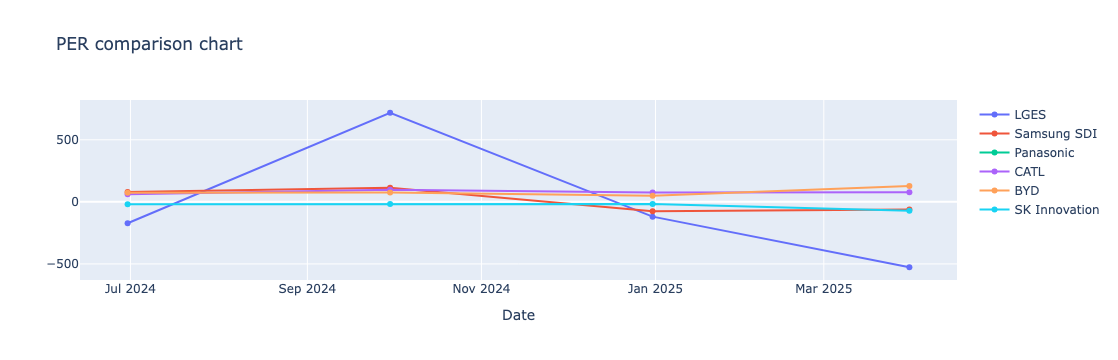


LGES has negative P/E meaning that it has negative income. 
Also we see lot of quarterly fluctuation in Korean battery industry (SK Innovation is excluded since it contains other industries).
While Korean battery market was fluctuating, Chinese companies have been pretty consistent.

Overall all Korean companies are suffering from negative income. Samsung SDI is only company where negative became smaller.

Chinese companies show increased P/E which can be due to
1. Increased valuation
2. Lower Net income
So further analysis is necessary




In [176]:
fig = create_comparison_chart(compare_per_df.iloc[3:], "PER comparison chart")
display(compare_per_df.iloc[3:])
fig.show()
print()
print("""LGES has negative P/E meaning that it has negative income. 
Also we see lot of quarterly fluctuation in Korean battery industry (SK Innovation is excluded since it contains other industries).
While Korean battery market was fluctuating, Chinese companies have been pretty consistent.

Overall all Korean companies are suffering from negative income. Samsung SDI is only company where negative became smaller.

Chinese companies show increased P/E which can be due to
1. Increased valuation
2. Lower Net income
So further analysis is necessary

""")

We can 

In [169]:
df_to_DFloader(compare_per_df.iloc[3:])

"pd.DataFrame({'date': ['2024-06-30', '2024-09-30', '2024-12-31', '2025-03-31'], 'LGES': [-172.1128002509687, 717.8722701192587, -119.12409274623673, -526.6364759160148], 'Samsung SDI': [79.48592877700439, 113.13228940805465, -75.76933319822851, -61.756535696871325], 'Panasonic': [nan, nan, nan, nan], 'CATL': [61.159513596368996, 97.76444729813865, 75.40676788543821, 77.00072379461031], 'BYD': [73.25761064900509, 75.04478638665609, 50.024035943140404, 128.201987256011], 'SK Innovation': [-18.92507271149216, -17.707275219011276, -16.63701015194504, -71.53161076956057]})"

In [104]:
stock_info['fundamental_analysis_df']

,net_income,share_issued,eps,Close_t+1,per
2025-03-31,-145740000000.0,234000000.0,-622.820513,328000.0,-526.636476
2024-12-31,-679661000000.0,234000000.0,-2904.534188,346000.0,-119.124093
2024-09-30,133156000000.0,234000000.0,569.042735,408500.0,717.87227
2024-06-30,-471772000000.0,234000000.0,-2016.119658,347000.0,-172.1128
2024-03-31,-464000000.0,234000000.0,-1.982906,395500.0,-199454.741379
2023-12-31,NaN,234000000.0,NaN,429500.0,NaN
2023-09-30,NaN,NaN,NaN,456000.0,NaN


In [100]:
stock_info['competitors'] = competitors

In [60]:
competitors.keys()

dict_keys(['Samsung SDI', 'Panasonic', 'CATL', 'BYD', 'SK Innovation'])

In [132]:
# PER comparison
compare_per_df = stock_info['fundamental_analysis_df'][['per']].rename(columns={"per":"LGES"})

for comp_nm, stk_info in stock_info['competitors'].items():
    comp_per_df = stk_info['fundamental_analysis_df'][['per']].rename(columns={"per":comp_nm})
    compare_per_df = pd.merge(compare_per_df, comp_per_df, how='left', left_index=True, right_index=True)

In [137]:
compare_per_df

,LGES,Samsung SDI,Panasonic,CATL,BYD,SK Innovation
2023-09-30,NaN,NaN,45.159589,NaN,NaN,NaN
2023-12-31,NaN,NaN,30.467653,NaN,NaN,NaN
2024-03-31,-199454.741379,116.276866,74.166865,78.852915,127.164127,-159.866282
2024-06-30,-172.1128,79.485929,NaN,61.159514,73.257611,-18.925073
2024-09-30,717.87227,113.132289,NaN,97.764447,75.044786,-17.707275
2024-12-31,-119.124093,-75.769333,NaN,75.406768,50.024036,-16.63701
2025-03-31,-526.636476,-61.756536,NaN,77.000724,128.201987,-71.531611


In [66]:
competitors['CATL']['fundamental_analysis_df']

,net_income,share_issued,eps,Close_t+1,per
2023-12-31,NaN,NaN,NaN,149.339371,NaN
2024-03-31,10509923000.0,4.399041e+09,2.389139,188.390610,78.852915
2024-06-30,12355064200.0,4.398807e+09,2.808731,171.780594,61.159514
2024-09-30,13136086400.0,4.402376e+09,2.983863,291.715729,97.764447
2024-12-31,14743608200.0,4.403466e+09,3.348182,252.475601,75.406768
2025-03-31,13962558000.0,4.403395e+09,3.170862,244.158676,77.000724


In [68]:
competitors['SK Innovation']['fundamental_analysis_df']

,net_income,share_issued,eps,Close_t+1,per
2025-03-31,-228953594000.0,148750403.0,-1539.179655,110100.000000,-71.531611
2024-12-31,-997935498000.0,152283202.0,-6553.155469,109024.914062,-16.63701
2024-09-30,-616533478000.0,95735590.0,-6439.961126,114034.164062,-17.707275
2024-06-30,-572885632000.0,95735590.0,-5984.040334,113248.398438,-18.925073
2024-03-31,-72602532000.0,100655564.0,-721.296758,115311.031250,-159.866282
2023-12-31,NaN,NaN,NaN,137705.343750,NaN
2023-09-30,NaN,NaN,NaN,138589.328125,NaN


In [67]:
competitors['BYD']['fundamental_analysis_df']

,net_income,share_issued,eps,Close_t+1,per
2023-09-30,NaN,NaN,NaN,235.035553,NaN
2023-12-31,NaN,NaN,NaN,206.271759,NaN
2024-03-31,4568793000.0,2.911143e+09,1.569416,199.573364,127.164127
2024-06-30,9062464000.0,2.909266e+09,3.115035,228.199997,73.257611
2024-09-30,11606858000.0,2.909266e+09,3.989618,299.399994,75.044786
2024-12-31,15016231000.0,2.909266e+09,5.161519,258.200012,50.024036
2025-03-31,9154985000.0,3.039066e+09,3.012434,386.200012,128.201987


In [63]:
competitors['Samsung SDI']['fundamental_analysis_df']

,net_income,share_issued,eps,Close_t+1,per
2025-03-31,-220547906430.0,71671422.0,-3077.208464,190037.734375,-61.756536
2024-12-31,-226546873840.0,71671422.0,-3160.909432,239500.000000,-75.769333
2024-09-30,229712896740.0,70231926.0,3270.775982,370030.375000,113.132289
2024-06-30,322989885810.0,70231926.0,4598.904006,365548.156250,79.485929
2024-03-31,273133934090.0,70231926.0,3889.028105,452204.000000,116.276866
2023-12-31,NaN,NaN,NaN,465152.562500,NaN
2023-09-30,NaN,NaN,NaN,481523.593750,NaN


In [ ]:
# Ratio analysis
revenue_related_stats = ['Total Revenue', 'Operating Revenue', 'Net Income']
cost_related_stats = ['Total Expenses', 'Cost Of Revenue','Operating Expense',
        'Other Operating Expenses', 'Interest Expense', 'Tax Provision']

dfs = []
for nm, ticker in tickers.tickers.items():
    stock_nm = stock_name_dict[nm]
    industry = ticker.info['industry']
    shares_outst = ticker.info['sharesOutstanding']
    curr_price = ticker.info['currentPrice'] # ??? Price on announcement date?
    balance_sheet = ticker.balance_sheet
    income_stmt = ticker.income_stmt
    
    # ROE
    shareholder_equity = balance_sheet.loc['Total Assets'] \
                    - balance_sheet.loc['Total Liabilities Net Minority Interest']
    roe = income_stmt.loc['Net Income'] / shareholder_equity
    roe.rename("roe", inplace=True)
    
    # P/E ratio
    pe_ratio = curr_price / income_stmt.loc['Basic EPS']
    pe_ratio.rename("pe_ratio", inplace=True)
    
    # P/B ratio
    book_value_ps = balance_sheet.loc['Stockholders Equity'] / shares_outst
    pb_ratio = curr_price / book_value_ps
    pb_ratio.rename("pb_ratio", inplace=True)
    
    df = pd.concat([roe, pe_ratio, pb_ratio], axis=1)
    df['company'] = [stock_nm]*len(roe)
    df['industry'] = [industry]*len(roe)

    # Revenue/Cost sources
    df = add_stats(df, income_stmt, revenue_related_stats)
    df = add_stats(df, income_stmt, cost_related_stats)

    dfs.append(df)

# Portfolio Analysis